# Classification Walk-through

links: 
- https://drivendata.github.io/cookiecutter-data-science/
- https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn import (ensemble, preprocessing, tree)
from sklearn.metrics import (auc, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (train_test_split, StratifiedKFold)

# Yellowbrick a visualization library for evaluating models
from yellowbrick.classifier import (ConfusionMatrix, ROCAUC)
from yellowbrick.model_selection import (LearningCurve)

In [2]:
# import sys
# sys.path

 /Users/ryantalbot/opt/anaconda3/envs/tf2/bin/python -m pip install pandas-profiling

## Import Data

In [3]:
train = pd.read_csv('./train.csv')

In [4]:
test = pd.read_csv('./test.csv')

In [5]:
train.shape

(891, 12)

In [6]:
test.shape

(418, 11)

In [7]:
submission = pd.read_csv('gender_submission.csv')

In [8]:
def concat_df(train, test):
    return pd.concat([train, test], sort=True).reset_index(drop=True)

In [9]:
df_all = concat_df(train, test)
dfs = [train, test]

In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [12]:
print('median for age separated by Pclass:')
display(train.groupby('Pclass')['Age'].median())

median for age separated by Pclass:


Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

Leaky features - are variables that contain information about the feature or target. 

In [13]:
train.describe().iloc[:, :2]

,PassengerId,Survived
count,891.000000,891.000000
mean,446.000000,0.383838
std,257.353842,0.486592
min,1.000000,0.000000
25%,223.500000,0.000000
50%,446.000000,0.000000
75%,668.500000,1.000000
max,891.000000,1.000000


In [14]:
train['Embarked'].replace('Q', 0,inplace=True)
train['Embarked'].replace('S', 1,inplace=True)
train['Embarked'].replace('C', 2,inplace=True)

test['Embarked'].replace('Q', 0,inplace=True)
test['Embarked'].replace('S', 1,inplace=True)
test['Embarked'].replace('C', 2,inplace=True)

train['Sex'].replace('male', 0,inplace=True)
train['Sex'].replace('female', 1,inplace=True)

test['Sex'].replace('male', 0,inplace=True)
test['Sex'].replace('female', 1,inplace=True)



In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,2.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,1.0


In [16]:
print('median for age separated by Pclass and sex:')
display(train.groupby(['Pclass', 'Sex'])['Age'].median())

median for age separated by Pclass and sex:


Pclass  Sex
1       0      40.0
        1      35.0
2       0      30.0
        1      28.0
3       0      25.0
        1      21.5
Name: Age, dtype: float64

In [17]:
print('Number of cases:')
display(train.groupby(['Pclass', 'Sex'])['Age'].count())

Number of cases:


Pclass  Sex
1       0      101
        1       85
2       0       99
        1       74
3       0      253
        1      102
Name: Age, dtype: int64

In [18]:
df_all['Age'] = df_all.groupby(
    ['Pclass', 'Sex'])['Age'].apply(
    lambda x: x.fillna(x.median()))



In [19]:
women = train.loc[train.Sex == 1]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [20]:
fares = train.loc[train.Fare > 100]["Survived"]
rate_fares = sum(fares)/len(fares)

print("% of fares over $100 who survived:", rate_fares)



% of fares over $100 who survived: 0.7358490566037735


In [21]:
df_all.loc[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [22]:
# mr_thomas = df_all.loc[(
#     df_all['Pclass'] == 3) & (
#     df_all['SibSp'] == 0) & (
#     df_all['Embarked'] == 'S')]['Fare'].median()

thomas=7.925

print(thomas)
df_all.loc[df_all['Fare'].isnull(), 'Fare'] = thomas

7.925


In [23]:
df_all['deck'] = df_all[
    'Cabin'].apply(
    lambda s: s[0] if pd.notnull(s) else 'M')

<AxesSubplot:xlabel='deck'>

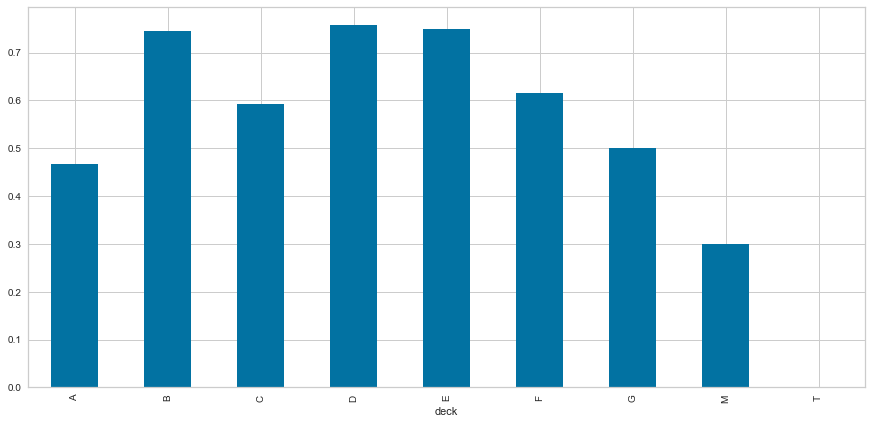

In [24]:
df_all[['deck', 'Survived']].groupby(
    'deck')['Survived'].mean().plot(kind='bar', figsize=(15,7))
# plot.subtitle('Survival rates for different cabines')

In [25]:
idx = df_all[df_all['deck'] == 'T'].index
df_all.loc[idx, 'deck'] = 'A'
df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['deck'] = df_all['deck'].replace(['D', 'E'], 'DE')
df_all['deck'] = df_all['deck'].replace(['F', 'G'], 'FG')

df_all['deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: deck, dtype: int64

In [26]:
df_all.loc[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,deck
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,ABC
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,ABC


In [27]:
df_all.loc[(df_all['Pclass'] == 1) & (
    df_all['Fare'] <= 80) & (
    df_all['deck'] == 'ABC')]['Embarked'].value_counts()

S    50
C    42
Name: Embarked, dtype: int64

In [28]:
df_all.loc[df_all['Embarked'].isnull(), 'Embarked'] = 'S'

# left off at 2.5 conclusion

<AxesSubplot:>

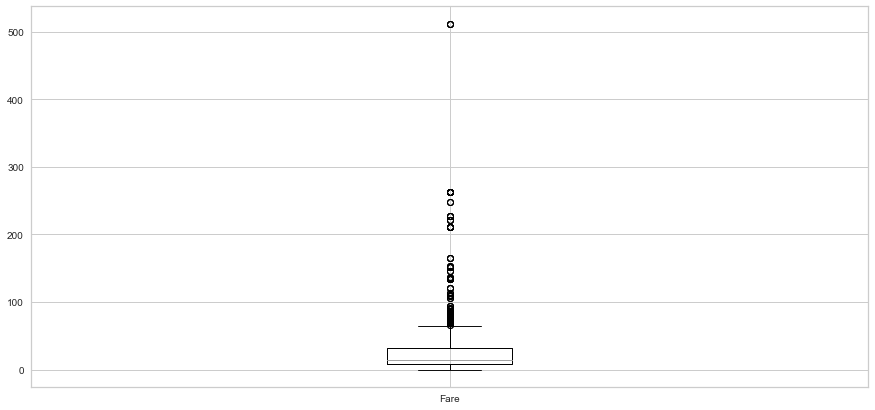

In [29]:
df_all.boxplot(column=['Fare'], figsize=(15, 7))

<AxesSubplot:>

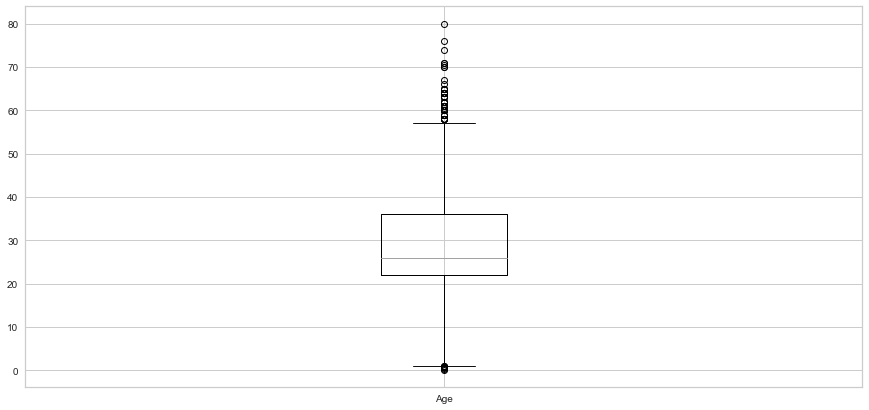

In [30]:
df_all.boxplot(column=['Age'], figsize=(15,7))

In [31]:
df_all['Fare'] = pd.cut(df_all['Fare'], 5)
df_all['Age'] = pd.cut(df_all['Age'].astype(int), 5)

In [32]:
print('for age, each category has a different number of cases: ')
df_all['Age'].value_counts()

for age, each category has a different number of cases: 


(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age, dtype: int64

In [33]:
print('for fare, each category has nearly a same number of cases:')
df_all['Fare'].value_counts()

for fare, each category has nearly a same number of cases:


(-0.512, 102.466]     1225
(102.466, 204.932]      46
(204.932, 307.398]      34
(409.863, 512.329]       4
(307.398, 409.863]       0
Name: Fare, dtype: int64

<AxesSubplot:xlabel='Age'>

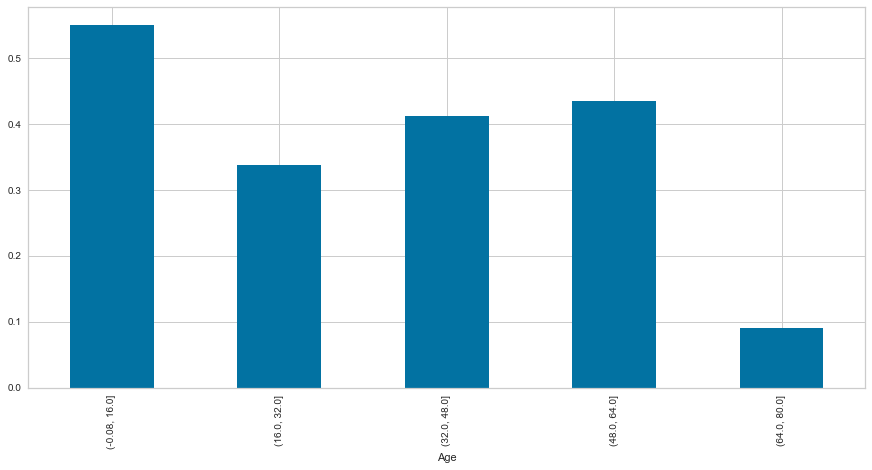

In [34]:
df_all[['Age', 'Survived']].groupby('Age')[
    'Survived'].mean().plot(kind='bar', figsize=(15,7))


<AxesSubplot:xlabel='Fare'>

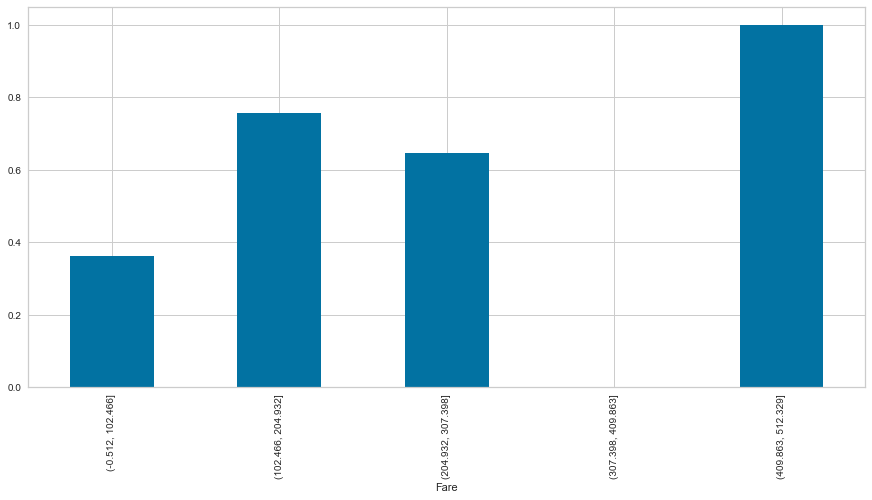

In [35]:
df_all[['Fare', 'Survived']].groupby(
    'Fare')['Survived'].mean().plot(kind='bar', figsize=(15,7))

In [36]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

<AxesSubplot:>

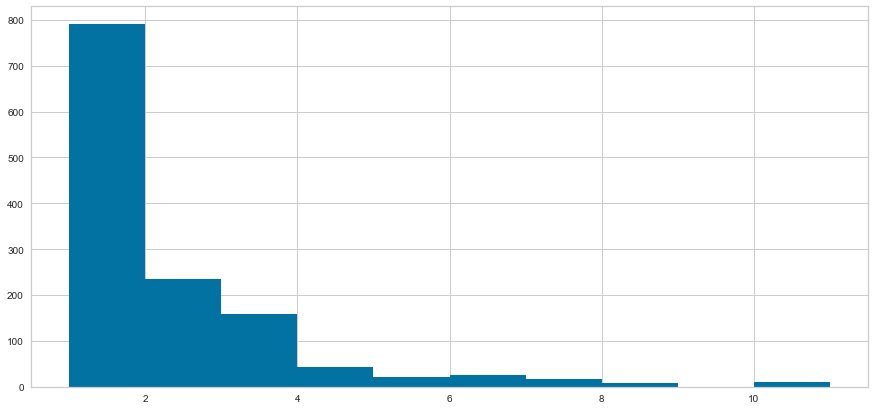

In [37]:
df_all['Family_Size'].hist(figsize=(15, 7))

In [38]:
df_all['Family_Size_bin'] = df_all['Family_Size'].map(
    lambda s: 1 if s == 1 else (2 if s == 2 else (
    3 if 3 <= s <= 4 else (4 if s >= 5 else 0))))

In [39]:
df_all['Family_Size_bin'].value_counts()

1    790
2    235
3    202
4     82
Name: Family_Size_bin, dtype: int64

<AxesSubplot:xlabel='Family_Size_bin'>

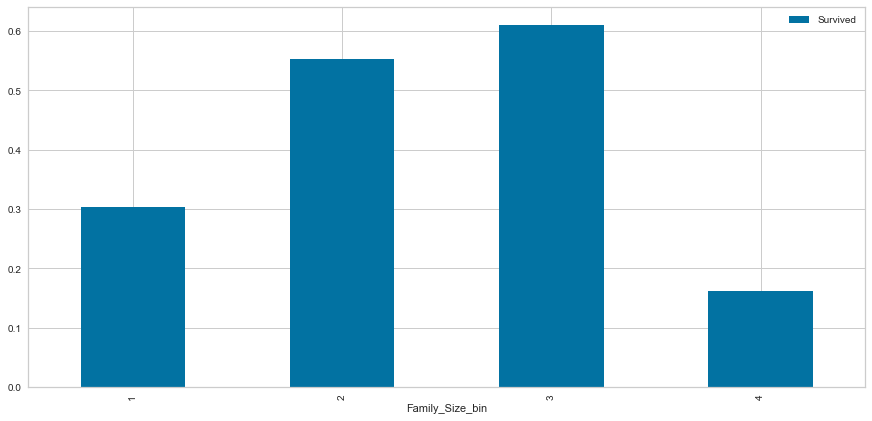

In [40]:
df_all[['Family_Size_bin', 'Survived']].groupby(
    'Family_Size_bin').mean().plot(kind='bar', figsize=(15, 7))

## 3.2 Tickets

In [41]:
df_all['Ticket_Frequency'] = df_all.groupby(
    'Ticket')['Ticket'].transform('count')

In [42]:
df_all[['Ticket_Frequency', 'Survived']].groupby(
    'Ticket_Frequency').mean()

,Survived
Ticket_Frequency,
1,0.270270
2,0.513812
3,0.653465
4,0.727273
5,0.333333
6,0.210526
7,0.208333
8,0.384615
11,0.000000


In [43]:
df_all['Title'] =  df_all['Name'].str.split(
    ', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == ' Mrs'] = 1

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [44]:
df_all['Title'].nunique()

18

In [45]:
title_names = (df_all['Title'].value_counts() < 10)

df_all['Title'] = df_all['Title'].apply(
    lambda x: 'Misc' if title_names.loc[x] == True else x)

df_all.groupby('Title')['Title'].count()

Title
Master     61
Misc       34
Miss      260
Mr        757
Mrs       197
Name: Title, dtype: int64

## 3.2.4 Survival rates

This Kaggle Competetion allows us to use information from the test data set. At this point we would like to point out that for high scores you have to be creative with the data. It is almost like a hackathon. In a Realworld task, you would not normally have the opportunity to do this.
We will identify family names of passengers. Then we can see if there are any family members that are present in both the training and the test data set.

In [46]:
import string

def extract_surname(data):
    families = []
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
        
    return families
df_all['Family'] = extract_surname(df_all['Name'])

In [47]:
df_all['Family'].nunique()

875

In [48]:
df_all[['Title', 'Survived', 'Family_Size']].groupby('Title').mean()

,Survived,Family_Size
Title,,
Master,0.575000,4.426230
Misc,0.444444,1.441176
Miss,0.697802,2.169231
Mr,0.156673,1.442536
Mrs,0.792000,2.492386


survival rates grouped by families of women in ds:


<AxesSubplot:>

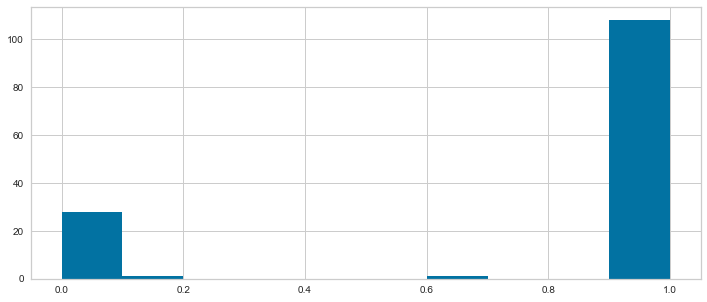

In [49]:
print('survival rates grouped by families of women in ds:')
df_all.loc[(df_all['Sex'] == 'female') & (
    df_all['Family_Size'] > 1)].groupby(
    'Family')['Survived'].mean().hist(figsize=(12,5))

<AxesSubplot:>

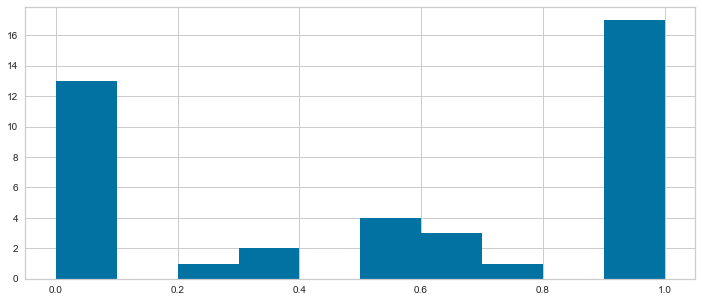

In [50]:
master_families = df_all.loc[df_all[
    'Title'] == 'Master']['Family'].tolist()
df_all.loc[df_all['Family'].isin(
    master_families)].groupby('Family')[
    'Survived'].mean().hist(figsize=(12,5))

In [51]:
# create variables iwth the survivla rate of the women and masters
women_rate = df_all.loc[(df_all['Sex'] == 'female') & (
    df_all['Family_Size'] > 1)].groupby('Family')['Survived'].mean()
master_rate = df_all.loc[df_all['Family'].isin(
    master_families)].groupby('Family')['Survived'].mean()

# Combine both series
combined_rate = women_rate.append(master_rate)

# It's possible that a woman has the family as a master and vice versa, do dup[licates have to be dropped
combined_rate_df = combined_rate.to_frame(
).reset_index().rename(columns={
    'Survived': 'Survival_quota'}).drop_duplicates(
    subset='Family')

# Merge the new df
df_all = pd.merge(df_all,combined_rate_df, how='left')

In [52]:
# we have calculated a surivival rate for only a part of the cases, the other cases we set to 0 in the dummy variables
df_all['Survival_quota_NA'] = 1
df_all.loc[df_all['Survival_quota'].isnull(), 'Survival_quota_NA'] = 0
df_all['Survival_quota'] = df_all['Survival_quota'].fillna(0)

## 3.3 Label and one hot encoding

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [54]:
non_numeric_features = ['Embarked', 'Sex', 'Title', 'Age', 'Fare', 'deck']

for feature in non_numeric_features:
    df_all[feature] = LabelEncoder().fit_transform(df_all[feature])
    
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'deck', 'Family_Size_bin', 'Age', 'Fare']

encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(
    df_all[feature].values.reshape(-1, 1)).toarray()
    n = df_all[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_all.index
    encoded_features.append(encoded_df)
    
df_all = pd.concat([df_all, *encoded_features], axis=1)

In [55]:
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [56]:
train, test = divide_df(df_all)

## 4. Modelling and prediction

For our first prediction we choose a Random Forrest Classifier. RFCs are easy to understand and proven tools for classification tasks.

We still define the columns that we do not need to consider for modelling. For Embarked, for example, we have created dummy columns, so we can drop the original Embarked column. As training/test split we choose 75% and 25%. We train the algorithm with the training data set and then test predictive power with the test data set.

The criteria in brackets for RFC are not mandatory, if you leave them out, default settings are used. The given parameters are already optimized so that our classifier works better than with the default parameters.

In [60]:
# Define columns which can be dropped from the modelling part b/c we created new label and one hot encoded variants out of them
drop_cols = ['Embarked', 'Family', 'Family_Size', 'Survived', 'Family_Size_bin', 'deck',
            'Age', 'Name', 'Parch',
            'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Title', 
            'Ticket', 'Cabin']

drop_cols_2 = ['Embarked', 'Family', 'Family_Size', 
            'Family_Size_bin', 'deck', 'Fare', 'Name', 'Parch',
            'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Title', 
            'Ticket', 'Cabin']

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [79]:
train_cols = train.columns

In [64]:
# Setting up a random forest classifier
# Standardization of the variables
X = StandardScaler().fit_transform(train.drop(columns=drop_cols))
y = train['Survived'].values
X_test = StandardScaler().fit_transform(test.drop(columns=drop_cols_2))

# creating train, test splits
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.25, random_state=42)

# defining model parameters
model = RandomForestClassifier(criterion='gini',
                              n_estimators =1750,
                              max_depth=7,
                              min_samples_split=6,
                              min_samples_leaf=6,
                              max_features='auto', 
                              oob_score=True, 
                              random_state=42,
                              n_jobs=-1,
                              verbose=1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(model.score(X_test1, y_test1))

output = pd.DataFrame({'PassengerId': test.PassengerId, 
                       'Survived': predictions})
output['Survived'] = output['Survived'].astype(int)
output.to_csv('2022_07_18_bd_final_v1.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s


0.8609865470852018


[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished


In [74]:
from sklearn.tree import export_graphviz
from sklearn import tree

In [82]:
estimator = model.estimators_[5]

export_graphviz(estimator,
                feature_names=train_cols,
                filled=True,
                rounded=True)

from Ipython.display import Image
Image(filename='tree.png')

ValueError: Length of feature_names, 51 does not match number of features, 35

In [67]:

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

FileNotFoundError: [Errno 2] No such file or directory: 'dot'